# 第13章: 実験と準実験 (Experiments and Quasi-Experiments)

この章では、因果効果を推定するための実験的・準実験的手法について学びます。

## 主なトピック
- ランダム化比較試験 (RCT)
- 差の差分析 (Difference-in-Differences: DID)
- 回帰不連続デザイン (Regression Discontinuity Design: RDD)

## 必要なパッケージ

In [1]:
# 必要なパッケージのインストールと読み込み
if (!require("AER")) install.packages("AER")
if (!require("dplyr")) install.packages("dplyr")
if (!require("ggplot2")) install.packages("ggplot2")
if (!require("lmtest")) install.packages("lmtest")
if (!require("sandwich")) install.packages("sandwich")

library(AER)
library(dplyr)
library(ggplot2)
library(lmtest)
library(sandwich)

Loading required package: AER



Loading required package: car



Loading required package: carData



Loading required package: lmtest



Loading required package: zoo




Attaching package: ‘zoo’




The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




Loading required package: sandwich



Loading required package: survival



Loading required package: dplyr




Attaching package: ‘dplyr’




The following object is masked from ‘package:car’:

    recode




The following objects are masked from ‘package:stats’:

    filter, lag




The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Loading required package: ggplot2



---
## 問題1: ランダム化比較試験の基礎

ある教育介入プログラムの効果を測定するために、100人の学生をランダムに処置群（50人）と対照群（50人）に分けました。

以下のシミュレーションデータを使って、処置効果を推定してください。

```r
set.seed(123)
n <- 100
treatment <- c(rep(1, 50), rep(0, 50))
# 真の処置効果は5点
y <- 70 + 5 * treatment + rnorm(n, 0, 10)
rct_data <- data.frame(treatment = treatment, score = y)
```

1. 処置群と対照群の平均点を計算してください
2. 単純な回帰分析で処置効果を推定してください
3. 推定された処置効果は真の値（5点）に近いですか？

In [2]:
# ここに回答を入力してください


### 模範解答

In [3]:
# データの生成
set.seed(123)
n <- 100
treatment <- c(rep(1, 50), rep(0, 50))
y <- 70 + 5 * treatment + rnorm(n, 0, 10)
rct_data <- data.frame(treatment = treatment, score = y)

# 1. 処置群と対照群の平均点
cat("処置群の平均点:", mean(rct_data$score[rct_data$treatment == 1]), "\n")
cat("対照群の平均点:", mean(rct_data$score[rct_data$treatment == 0]), "\n")
cat("平均の差:", mean(rct_data$score[rct_data$treatment == 1]) - mean(rct_data$score[rct_data$treatment == 0]), "\n\n")

# 2. 回帰分析による処置効果の推定
model_rct <- lm(score ~ treatment, data = rct_data)
summary(model_rct)

# 3. 推定値と真の値の比較
cat("\n推定された処置効果:", coef(model_rct)["treatment"], "\n")
cat("真の処置効果: 5\n")
cat("推定値は真の値に近い値を示しています。")

処置群の平均点: 75.34404 


対照群の平均点: 71.46408 


平均の差: 3.879953 




Call:
lm(formula = score ~ treatment, data = rct_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-24.5558  -5.9140  -0.5798   6.5742  21.3455 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   71.464      1.295  55.184   <2e-16 ***
treatment      3.880      1.831   2.119   0.0367 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.157 on 98 degrees of freedom
Multiple R-squared:  0.04379,	Adjusted R-squared:  0.03404 
F-statistic: 4.488 on 1 and 98 DF,  p-value: 0.03666



推定された処置効果: 3.879953 


真の処置効果: 5


推定値は真の値に近い値を示しています。

---
## 問題2: RCTにおける共変量の調整

問題1のデータに、学生の事前テストスコア（共変量）を追加します。

```r
set.seed(123)
n <- 100
treatment <- c(rep(1, 50), rep(0, 50))
pretest <- rnorm(n, 60, 15)
y <- 20 + 0.8 * pretest + 5 * treatment + rnorm(n, 0, 8)
rct_data2 <- data.frame(treatment = treatment, pretest = pretest, score = y)
```

1. 共変量なしで処置効果を推定してください
2. 共変量（pretest）を含めて処置効果を推定してください
3. 共変量を含めることで標準誤差がどう変化するか比較してください

In [4]:
# ここに回答を入力してください


### 模範解答

In [5]:
# データの生成
set.seed(123)
n <- 100
treatment <- c(rep(1, 50), rep(0, 50))
pretest <- rnorm(n, 60, 15)
y <- 20 + 0.8 * pretest + 5 * treatment + rnorm(n, 0, 8)
rct_data2 <- data.frame(treatment = treatment, pretest = pretest, score = y)

# 1. 共変量なしのモデル
model_simple <- lm(score ~ treatment, data = rct_data2)
cat("共変量なしのモデル:\n")
summary(model_simple)

# 2. 共変量ありのモデル
model_cov <- lm(score ~ treatment + pretest, data = rct_data2)
cat("\n共変量ありのモデル:\n")
summary(model_cov)

# 3. 標準誤差の比較
se_simple <- summary(model_simple)$coefficients["treatment", "Std. Error"]
se_cov <- summary(model_cov)$coefficients["treatment", "Std. Error"]

cat("\n標準誤差の比較:\n")
cat("共変量なし:", se_simple, "\n")
cat("共変量あり:", se_cov, "\n")
cat("標準誤差の減少率:", (se_simple - se_cov) / se_simple * 100, "%\n")
cat("\n共変量を含めることで残差の分散が減少し、推定の精度が向上します。")

共変量なしのモデル:



Call:
lm(formula = score ~ treatment, data = rct_data2)

Residuals:
    Min      1Q  Median      3Q     Max 
-29.255  -9.669   1.497   8.523  28.986 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   70.067      1.842  38.031   <2e-16 ***
treatment      1.314      2.606   0.504    0.615    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 13.03 on 98 degrees of freedom
Multiple R-squared:  0.00259,	Adjusted R-squared:  -0.007588 
F-statistic: 0.2544 on 1 and 98 DF,  p-value: 0.6151



共変量ありのモデル:



Call:
lm(formula = score ~ treatment + pretest, data = rct_data2)

Residuals:
     Min       1Q   Median       3Q      Max 
-14.0003  -5.4270  -0.8285   4.4710  25.0340 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  22.3885     3.6915   6.065 2.54e-08 ***
treatment     2.6022     1.5450   1.684   0.0954 .  
pretest       0.7666     0.0567  13.519  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7.711 on 97 degrees of freedom
Multiple R-squared:  0.6542,	Adjusted R-squared:  0.647 
F-statistic: 91.74 on 2 and 97 DF,  p-value: < 2.2e-16



標準誤差の比較:


共変量なし: 2.605525 


共変量あり: 1.545041 


標準誤差の減少率: 40.70135 %



共変量を含めることで残差の分散が減少し、推定の精度が向上します。

---
## 問題3: 差の差分析（DID）の基礎

ある政策が2つの地域のうち1つでのみ実施されました。政策実施前後のデータがあります。

```r
set.seed(42)
did_data <- data.frame(
  region = rep(c("treatment", "control"), each = 100),
  period = rep(c("before", "after"), times = 100),
  outcome = c(
    rnorm(50, 50, 5),  # treatment, before
    rnorm(50, 60, 5),  # treatment, after (真の効果 = 5)
    rnorm(50, 45, 5),  # control, before
    rnorm(50, 50, 5)   # control, after
  )
)
```

1. 各グループ・期間の平均を計算してください
2. DID推定量を手計算で求めてください
3. 回帰分析でDID推定を行ってください

In [6]:
# ここに回答を入力してください


### 模範解答

In [7]:
# データの生成
set.seed(42)
did_data <- data.frame(
  region = rep(c("treatment", "control"), each = 100),
  period = rep(c("before", "after"), times = 100),
  outcome = c(
    rnorm(50, 50, 5),  # treatment, before
    rnorm(50, 60, 5),  # treatment, after (真の効果 = 5)
    rnorm(50, 45, 5),  # control, before
    rnorm(50, 50, 5)   # control, after
  )
)

# ダミー変数の作成
did_data$treat <- ifelse(did_data$region == "treatment", 1, 0)
did_data$post <- ifelse(did_data$period == "after", 1, 0)

# 1. 各グループ・期間の平均
means <- aggregate(outcome ~ region + period, data = did_data, mean)
print(means)

# 2. DID推定量の手計算
mean_treat_after <- mean(did_data$outcome[did_data$treat == 1 & did_data$post == 1])
mean_treat_before <- mean(did_data$outcome[did_data$treat == 1 & did_data$post == 0])
mean_control_after <- mean(did_data$outcome[did_data$treat == 0 & did_data$post == 1])
mean_control_before <- mean(did_data$outcome[did_data$treat == 0 & did_data$post == 0])

did_estimate <- (mean_treat_after - mean_treat_before) - (mean_control_after - mean_control_before)
cat("\nDID推定量（手計算）:", did_estimate, "\n")

# 3. 回帰分析によるDID
model_did <- lm(outcome ~ treat + post + treat:post, data = did_data)
summary(model_did)

cat("\nDID推定量（回帰分析）:", coef(model_did)["treat:post"], "\n")
cat("真の処置効果: 5\n")

     region period  outcome
1   control  after 47.39843
2 treatment  after 55.14155
3   control before 46.72673
4 treatment before 55.18360



DID推定量（手計算）: -0.7137564 



Call:
lm(formula = outcome ~ treat + post + treat:post, data = did_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-18.4238  -4.2950  -0.1635   5.2269  12.6950 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  46.7267     0.9215  50.709  < 2e-16 ***
treat         8.4569     1.3032   6.489 6.89e-10 ***
post          0.6717     1.3032   0.515    0.607    
treat:post   -0.7138     1.8430  -0.387    0.699    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.516 on 196 degrees of freedom
Multiple R-squared:  0.2835,	Adjusted R-squared:  0.2725 
F-statistic: 25.84 on 3 and 196 DF,  p-value: 3.938e-14



DID推定量（回帰分析）: -0.7137564 


真の処置効果: 5


---
## 問題4: DIDの平行トレンド仮定

DIDの重要な仮定である「平行トレンド仮定」について考えます。

以下の2つのシナリオについて、DID推定が適切かどうか検討してください。

```r
# シナリオA: 平行トレンドが成り立つ
set.seed(1)
time <- 1:10
treatment_trend_A <- 30 + 2 * time + ifelse(time > 5, 10, 0) + rnorm(10, 0, 2)
control_trend_A <- 25 + 2 * time + rnorm(10, 0, 2)

# シナリオB: 平行トレンドが成り立たない
treatment_trend_B <- 30 + 3 * time + ifelse(time > 5, 10, 0) + rnorm(10, 0, 2)
control_trend_B <- 25 + 1 * time + rnorm(10, 0, 2)
```

1. 両シナリオのグラフを作成してください
2. どちらのシナリオでDIDが適切に使えるか説明してください

In [8]:
# ここに回答を入力してください


### 模範解答

Warning message in title(...):
“conversion failure on 'シナリオA: 平行トレンド' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'シナリオA: 平行トレンド' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on 'シナリオA: 平行トレンド' in 'mbcsToSbcs': dot substituted for <b7>”


Warning message in title(...):
“conversion failure on 'シナリオA: 平行トレンド' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'シナリオA: 平行トレンド' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'シナリオA: 平行トレンド' in 'mbcsToSbcs': dot substituted for <8a>”


Warning message in title(...):
“conversion failure on 'シナリオA: 平行トレンド' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'シナリオA: 平行トレンド' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'シナリオA: 平行トレンド' in 'mbcsToSbcs': dot substituted for <aa>”


Warning message in title(...):
“conversion failure on 'シナリオA: 平行トレンド' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'シナリオA: 平行トレンド' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on 'シナリオA: 平行トレンド' in 'mbcsToSbcs': dot substituted for <aa>”


Warning message in title(...):
“conversion failure on 'シナリオA: 平行トレンド' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on 'シナリオA: 平行トレンド' in 'mbcsToSbcs': dot substituted for <b9>”


Warning message in title(...):
“conversion failure on 'シナリオA: 平行トレンド' in 'mbcsToSbcs': dot substituted for <b3>”


Warning message in title(...):
“conversion failure on 'シナリオA: 平行トレンド' in 'mbcsToSbcs': dot substituted for <e8>”


Warning message in title(...):
“conversion failure on 'シナリオA: 平行トレンド' in 'mbcsToSbcs': dot substituted for <a1>”


Warning message in title(...):
“conversion failure on 'シナリオA: 平行トレンド' in 'mbcsToSbcs': dot substituted for <8c>”


Warning message in title(...):
“conversion failure on 'シナリオA: 平行トレンド' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'シナリオA: 平行トレンド' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'シナリオA: 平行トレンド' in 'mbcsToSbcs': dot substituted for <88>”


Warning message in title(...):
“conversion failure on 'シナリオA: 平行トレンド' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'シナリオA: 平行トレンド' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'シナリオA: 平行トレンド' in 'mbcsToSbcs': dot substituted for <ac>”


Warning message in title(...):
“conversion failure on 'シナリオA: 平行トレンド' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'シナリオA: 平行トレンド' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'シナリオA: 平行トレンド' in 'mbcsToSbcs': dot substituted for <b3>”


Warning message in title(...):
“conversion failure on 'シナリオA: 平行トレンド' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'シナリオA: 平行トレンド' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'シナリオA: 平行トレンド' in 'mbcsToSbcs': dot substituted for <89>”


Warning message in title(...):
“conversion failure on '時間' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(...):
“conversion failure on '時間' in 'mbcsToSbcs': dot substituted for <99>”


Warning message in title(...):
“conversion failure on '時間' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on '時間' in 'mbcsToSbcs': dot substituted for <e9>”


Warning message in title(...):
“conversion failure on '時間' in 'mbcsToSbcs': dot substituted for <96>”


Warning message in title(...):
“conversion failure on '時間' in 'mbcsToSbcs': dot substituted for <93>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <a2>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <a6>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <88>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <ab>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <a0>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <87>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <a6>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <bd>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <ae>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <be>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <a4>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <af>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <be>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <85>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <a7>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <be>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <a4>”


Warning message in text.default(x, y, ...):
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in text.default(x, y, ...):
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <87>”


Warning message in text.default(x, y, ...):
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <a6>”


Warning message in text.default(x, y, ...):
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in text.default(x, y, ...):
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <bd>”


Warning message in text.default(x, y, ...):
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <ae>”


Warning message in text.default(x, y, ...):
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in text.default(x, y, ...):
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <be>”


Warning message in text.default(x, y, ...):
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <a4>”


Warning message in text.default(x, y, ...):
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in text.default(x, y, ...):
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <af>”


Warning message in text.default(x, y, ...):
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <be>”


Warning message in text.default(x, y, ...):
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in text.default(x, y, ...):
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <85>”


Warning message in text.default(x, y, ...):
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <a7>”


Warning message in text.default(x, y, ...):
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in text.default(x, y, ...):
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <be>”


Warning message in text.default(x, y, ...):
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <a4>”


Warning message in title(...):
“conversion failure on 'シナリオB: 非平行トレンド' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'シナリオB: 非平行トレンド' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on 'シナリオB: 非平行トレンド' in 'mbcsToSbcs': dot substituted for <b7>”


Warning message in title(...):
“conversion failure on 'シナリオB: 非平行トレンド' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'シナリオB: 非平行トレンド' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'シナリオB: 非平行トレンド' in 'mbcsToSbcs': dot substituted for <8a>”


Warning message in title(...):
“conversion failure on 'シナリオB: 非平行トレンド' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'シナリオB: 非平行トレンド' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'シナリオB: 非平行トレンド' in 'mbcsToSbcs': dot substituted for <aa>”


Warning message in title(...):
“conversion failure on 'シナリオB: 非平行トレンド' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'シナリオB: 非平行トレンド' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on 'シナリオB: 非平行トレンド' in 'mbcsToSbcs': dot substituted for <aa>”


Warning message in title(...):
“conversion failure on 'シナリオB: 非平行トレンド' in 'mbcsToSbcs': dot substituted for <e9>”


Warning message in title(...):
“conversion failure on 'シナリオB: 非平行トレンド' in 'mbcsToSbcs': dot substituted for <9d>”


Warning message in title(...):
“conversion failure on 'シナリオB: 非平行トレンド' in 'mbcsToSbcs': dot substituted for <9e>”


Warning message in title(...):
“conversion failure on 'シナリオB: 非平行トレンド' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on 'シナリオB: 非平行トレンド' in 'mbcsToSbcs': dot substituted for <b9>”


Warning message in title(...):
“conversion failure on 'シナリオB: 非平行トレンド' in 'mbcsToSbcs': dot substituted for <b3>”


Warning message in title(...):
“conversion failure on 'シナリオB: 非平行トレンド' in 'mbcsToSbcs': dot substituted for <e8>”


Warning message in title(...):
“conversion failure on 'シナリオB: 非平行トレンド' in 'mbcsToSbcs': dot substituted for <a1>”


Warning message in title(...):
“conversion failure on 'シナリオB: 非平行トレンド' in 'mbcsToSbcs': dot substituted for <8c>”


Warning message in title(...):
“conversion failure on 'シナリオB: 非平行トレンド' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'シナリオB: 非平行トレンド' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'シナリオB: 非平行トレンド' in 'mbcsToSbcs': dot substituted for <88>”


Warning message in title(...):
“conversion failure on 'シナリオB: 非平行トレンド' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'シナリオB: 非平行トレンド' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'シナリオB: 非平行トレンド' in 'mbcsToSbcs': dot substituted for <ac>”


Warning message in title(...):
“conversion failure on 'シナリオB: 非平行トレンド' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'シナリオB: 非平行トレンド' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'シナリオB: 非平行トレンド' in 'mbcsToSbcs': dot substituted for <b3>”


Warning message in title(...):
“conversion failure on 'シナリオB: 非平行トレンド' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'シナリオB: 非平行トレンド' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'シナリオB: 非平行トレンド' in 'mbcsToSbcs': dot substituted for <89>”


Warning message in title(...):
“conversion failure on '時間' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(...):
“conversion failure on '時間' in 'mbcsToSbcs': dot substituted for <99>”


Warning message in title(...):
“conversion failure on '時間' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on '時間' in 'mbcsToSbcs': dot substituted for <e9>”


Warning message in title(...):
“conversion failure on '時間' in 'mbcsToSbcs': dot substituted for <96>”


Warning message in title(...):
“conversion failure on '時間' in 'mbcsToSbcs': dot substituted for <93>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <a2>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <a6>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <88>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <ab>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <a0>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <87>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <a6>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <bd>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <ae>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <be>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <a4>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <af>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <be>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <85>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <a7>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <be>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <a4>”


Warning message in text.default(x, y, ...):
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in text.default(x, y, ...):
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <87>”


Warning message in text.default(x, y, ...):
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <a6>”


Warning message in text.default(x, y, ...):
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in text.default(x, y, ...):
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <bd>”


Warning message in text.default(x, y, ...):
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <ae>”


Warning message in text.default(x, y, ...):
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in text.default(x, y, ...):
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <be>”


Warning message in text.default(x, y, ...):
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <a4>”


Warning message in text.default(x, y, ...):
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in text.default(x, y, ...):
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <af>”


Warning message in text.default(x, y, ...):
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <be>”


Warning message in text.default(x, y, ...):
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in text.default(x, y, ...):
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <85>”


Warning message in text.default(x, y, ...):
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <a7>”


Warning message in text.default(x, y, ...):
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in text.default(x, y, ...):
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <be>”


Warning message in text.default(x, y, ...):
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <a4>”



解説:


シナリオA: 処置前のトレンドが平行（両群とも傾き2）なので、DIDが適切に使えます。


シナリオB: 処置前のトレンドが異なる（処置群は傾き3、対照群は傾き1）ため、


          DIDは処置効果を過大または過小に推定する可能性があります。


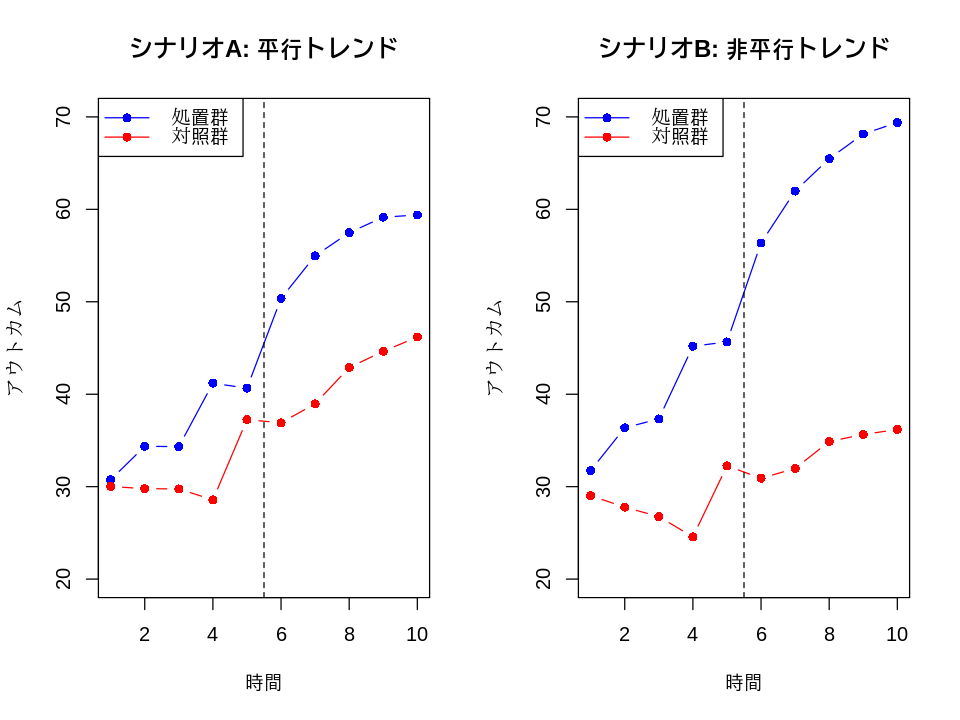

In [9]:
# シナリオA: 平行トレンドが成り立つ
set.seed(1)
time <- 1:10
treatment_trend_A <- 30 + 2 * time + ifelse(time > 5, 10, 0) + rnorm(10, 0, 2)
control_trend_A <- 25 + 2 * time + rnorm(10, 0, 2)

# シナリオB: 平行トレンドが成り立たない
set.seed(1)
treatment_trend_B <- 30 + 3 * time + ifelse(time > 5, 10, 0) + rnorm(10, 0, 2)
control_trend_B <- 25 + 1 * time + rnorm(10, 0, 2)

# グラフの作成
par(mfrow = c(1, 2))

# シナリオA
plot(time, treatment_trend_A, type = "b", col = "blue", ylim = c(20, 70),
     main = "シナリオA: 平行トレンド", xlab = "時間", ylab = "アウトカム", pch = 16)
lines(time, control_trend_A, type = "b", col = "red", pch = 16)
abline(v = 5.5, lty = 2)
legend("topleft", legend = c("処置群", "対照群"), col = c("blue", "red"), lty = 1, pch = 16)

# シナリオB
plot(time, treatment_trend_B, type = "b", col = "blue", ylim = c(20, 70),
     main = "シナリオB: 非平行トレンド", xlab = "時間", ylab = "アウトカム", pch = 16)
lines(time, control_trend_B, type = "b", col = "red", pch = 16)
abline(v = 5.5, lty = 2)
legend("topleft", legend = c("処置群", "対照群"), col = c("blue", "red"), lty = 1, pch = 16)

par(mfrow = c(1, 1))

cat("\n解説:\n")
cat("シナリオA: 処置前のトレンドが平行（両群とも傾き2）なので、DIDが適切に使えます。\n")
cat("シナリオB: 処置前のトレンドが異なる（処置群は傾き3、対照群は傾き1）ため、\n")
cat("          DIDは処置効果を過大または過小に推定する可能性があります。\n")

---
## 問題5: 回帰不連続デザイン（RDD）の基礎

奨学金プログラムでは、試験スコア60点以上の学生が奨学金を受け取ります。

```r
set.seed(456)
n <- 200
test_score <- runif(n, 40, 80)
scholarship <- ifelse(test_score >= 60, 1, 0)
# 奨学金の効果は成績を10ポイント上昇させる
gpa <- 2.0 + 0.03 * test_score + 0.5 * scholarship + rnorm(n, 0, 0.3)
rdd_data <- data.frame(test_score = test_score, scholarship = scholarship, gpa = gpa)
```

1. データを可視化し、閾値での不連続性を確認してください
2. 単純なRDD回帰で効果を推定してください
3. 閾値を中心としたスコアを使って推定してください

In [10]:
# ここに回答を入力してください


### 模範解答

Warning message in title(...):
“conversion failure on 'RDD: 奨学金と成績の関係' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on 'RDD: 奨学金と成績の関係' in 'mbcsToSbcs': dot substituted for <a5>”


Warning message in title(...):
“conversion failure on 'RDD: 奨学金と成績の関係' in 'mbcsToSbcs': dot substituted for <a8>”


Warning message in title(...):
“conversion failure on 'RDD: 奨学金と成績の関係' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on 'RDD: 奨学金と成績の関係' in 'mbcsToSbcs': dot substituted for <ad>”


Warning message in title(...):
“conversion failure on 'RDD: 奨学金と成績の関係' in 'mbcsToSbcs': dot substituted for <a6>”


Warning message in title(...):
“conversion failure on 'RDD: 奨学金と成績の関係' in 'mbcsToSbcs': dot substituted for <e9>”


Warning message in title(...):
“conversion failure on 'RDD: 奨学金と成績の関係' in 'mbcsToSbcs': dot substituted for <87>”


Warning message in title(...):
“conversion failure on 'RDD: 奨学金と成績の関係' in 'mbcsToSbcs': dot substituted for <91>”


Warning message in title(...):
“conversion failure on 'RDD: 奨学金と成績の関係' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'RDD: 奨学金と成績の関係' in 'mbcsToSbcs': dot substituted for <81>”


Warning message in title(...):
“conversion failure on 'RDD: 奨学金と成績の関係' in 'mbcsToSbcs': dot substituted for <a8>”


Warning message in title(...):
“conversion failure on 'RDD: 奨学金と成績の関係' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(...):
“conversion failure on 'RDD: 奨学金と成績の関係' in 'mbcsToSbcs': dot substituted for <88>”


Warning message in title(...):
“conversion failure on 'RDD: 奨学金と成績の関係' in 'mbcsToSbcs': dot substituted for <90>”


Warning message in title(...):
“conversion failure on 'RDD: 奨学金と成績の関係' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(...):
“conversion failure on 'RDD: 奨学金と成績の関係' in 'mbcsToSbcs': dot substituted for <b8>”


Warning message in title(...):
“conversion failure on 'RDD: 奨学金と成績の関係' in 'mbcsToSbcs': dot substituted for <be>”


Warning message in title(...):
“conversion failure on 'RDD: 奨学金と成績の関係' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'RDD: 奨学金と成績の関係' in 'mbcsToSbcs': dot substituted for <81>”


Warning message in title(...):
“conversion failure on 'RDD: 奨学金と成績の関係' in 'mbcsToSbcs': dot substituted for <ae>”


Warning message in title(...):
“conversion failure on 'RDD: 奨学金と成績の関係' in 'mbcsToSbcs': dot substituted for <e9>”


Warning message in title(...):
“conversion failure on 'RDD: 奨学金と成績の関係' in 'mbcsToSbcs': dot substituted for <96>”


Warning message in title(...):
“conversion failure on 'RDD: 奨学金と成績の関係' in 'mbcsToSbcs': dot substituted for <a2>”


Warning message in title(...):
“conversion failure on 'RDD: 奨学金と成績の関係' in 'mbcsToSbcs': dot substituted for <e4>”


Warning message in title(...):
“conversion failure on 'RDD: 奨学金と成績の関係' in 'mbcsToSbcs': dot substituted for <bf>”


Warning message in title(...):
“conversion failure on 'RDD: 奨学金と成績の関係' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <e8>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <a9>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <a6>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <e9>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <a8>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <93>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <b9>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <b3>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <a2>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '奨学金あり' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '奨学金あり' in 'mbcsToSbcs': dot substituted for <a5>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '奨学金あり' in 'mbcsToSbcs': dot substituted for <a8>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '奨学金あり' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '奨学金あり' in 'mbcsToSbcs': dot substituted for <ad>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '奨学金あり' in 'mbcsToSbcs': dot substituted for <a6>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '奨学金あり' in 'mbcsToSbcs': dot substituted for <e9>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '奨学金あり' in 'mbcsToSbcs': dot substituted for <87>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '奨学金あり' in 'mbcsToSbcs': dot substituted for <91>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '奨学金あり' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '奨学金あり' in 'mbcsToSbcs': dot substituted for <81>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '奨学金あり' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '奨学金あり' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '奨学金あり' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '奨学金あり' in 'mbcsToSbcs': dot substituted for <8a>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '奨学金なし' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '奨学金なし' in 'mbcsToSbcs': dot substituted for <a5>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '奨学金なし' in 'mbcsToSbcs': dot substituted for <a8>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '奨学金なし' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '奨学金なし' in 'mbcsToSbcs': dot substituted for <ad>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '奨学金なし' in 'mbcsToSbcs': dot substituted for <a6>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '奨学金なし' in 'mbcsToSbcs': dot substituted for <e9>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '奨学金なし' in 'mbcsToSbcs': dot substituted for <87>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '奨学金なし' in 'mbcsToSbcs': dot substituted for <91>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '奨学金なし' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '奨学金なし' in 'mbcsToSbcs': dot substituted for <81>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '奨学金なし' in 'mbcsToSbcs': dot substituted for <aa>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '奨学金なし' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '奨学金なし' in 'mbcsToSbcs': dot substituted for <81>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '奨学金なし' in 'mbcsToSbcs': dot substituted for <97>”


Warning message in text.default(x, y, ...):
“conversion failure on '奨学金あり' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in text.default(x, y, ...):
“conversion failure on '奨学金あり' in 'mbcsToSbcs': dot substituted for <a5>”


Warning message in text.default(x, y, ...):
“conversion failure on '奨学金あり' in 'mbcsToSbcs': dot substituted for <a8>”


Warning message in text.default(x, y, ...):
“conversion failure on '奨学金あり' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in text.default(x, y, ...):
“conversion failure on '奨学金あり' in 'mbcsToSbcs': dot substituted for <ad>”


Warning message in text.default(x, y, ...):
“conversion failure on '奨学金あり' in 'mbcsToSbcs': dot substituted for <a6>”


Warning message in text.default(x, y, ...):
“conversion failure on '奨学金あり' in 'mbcsToSbcs': dot substituted for <e9>”


Warning message in text.default(x, y, ...):
“conversion failure on '奨学金あり' in 'mbcsToSbcs': dot substituted for <87>”


Warning message in text.default(x, y, ...):
“conversion failure on '奨学金あり' in 'mbcsToSbcs': dot substituted for <91>”


Warning message in text.default(x, y, ...):
“conversion failure on '奨学金あり' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in text.default(x, y, ...):
“conversion failure on '奨学金あり' in 'mbcsToSbcs': dot substituted for <81>”


Warning message in text.default(x, y, ...):
“conversion failure on '奨学金あり' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in text.default(x, y, ...):
“conversion failure on '奨学金あり' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in text.default(x, y, ...):
“conversion failure on '奨学金あり' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in text.default(x, y, ...):
“conversion failure on '奨学金あり' in 'mbcsToSbcs': dot substituted for <8a>”


Warning message in text.default(x, y, ...):
“conversion failure on '奨学金なし' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in text.default(x, y, ...):
“conversion failure on '奨学金なし' in 'mbcsToSbcs': dot substituted for <a5>”


Warning message in text.default(x, y, ...):
“conversion failure on '奨学金なし' in 'mbcsToSbcs': dot substituted for <a8>”


Warning message in text.default(x, y, ...):
“conversion failure on '奨学金なし' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in text.default(x, y, ...):
“conversion failure on '奨学金なし' in 'mbcsToSbcs': dot substituted for <ad>”


Warning message in text.default(x, y, ...):
“conversion failure on '奨学金なし' in 'mbcsToSbcs': dot substituted for <a6>”


Warning message in text.default(x, y, ...):
“conversion failure on '奨学金なし' in 'mbcsToSbcs': dot substituted for <e9>”


Warning message in text.default(x, y, ...):
“conversion failure on '奨学金なし' in 'mbcsToSbcs': dot substituted for <87>”


Warning message in text.default(x, y, ...):
“conversion failure on '奨学金なし' in 'mbcsToSbcs': dot substituted for <91>”


Warning message in text.default(x, y, ...):
“conversion failure on '奨学金なし' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in text.default(x, y, ...):
“conversion failure on '奨学金なし' in 'mbcsToSbcs': dot substituted for <81>”


Warning message in text.default(x, y, ...):
“conversion failure on '奨学金なし' in 'mbcsToSbcs': dot substituted for <aa>”


Warning message in text.default(x, y, ...):
“conversion failure on '奨学金なし' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in text.default(x, y, ...):
“conversion failure on '奨学金なし' in 'mbcsToSbcs': dot substituted for <81>”


Warning message in text.default(x, y, ...):
“conversion failure on '奨学金なし' in 'mbcsToSbcs': dot substituted for <97>”


単純なRDD回帰:



Call:
lm(formula = gpa ~ test_score + scholarship, data = rdd_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.72342 -0.22496 -0.00775  0.23843  0.79630 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.931910   0.183604  10.522  < 2e-16 ***
test_score  0.031044   0.003557   8.728 1.10e-15 ***
scholarship 0.501735   0.081813   6.133 4.64e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2914 on 197 degrees of freedom
Multiple R-squared:  0.8036,	Adjusted R-squared:  0.8016 
F-statistic: 402.9 on 2 and 197 DF,  p-value: < 2.2e-16



センタリングしたRDD回帰:



Call:
lm(formula = gpa ~ score_centered + scholarship, data = rdd_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.72342 -0.22496 -0.00775  0.23843  0.79630 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    3.794553   0.044509  85.254  < 2e-16 ***
score_centered 0.031044   0.003557   8.728 1.10e-15 ***
scholarship    0.501735   0.081813   6.133 4.64e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2914 on 197 degrees of freedom
Multiple R-squared:  0.8036,	Adjusted R-squared:  0.8016 
F-statistic: 402.9 on 2 and 197 DF,  p-value: < 2.2e-16



推定された奨学金効果: 0.5017353 


真の効果: 0.5


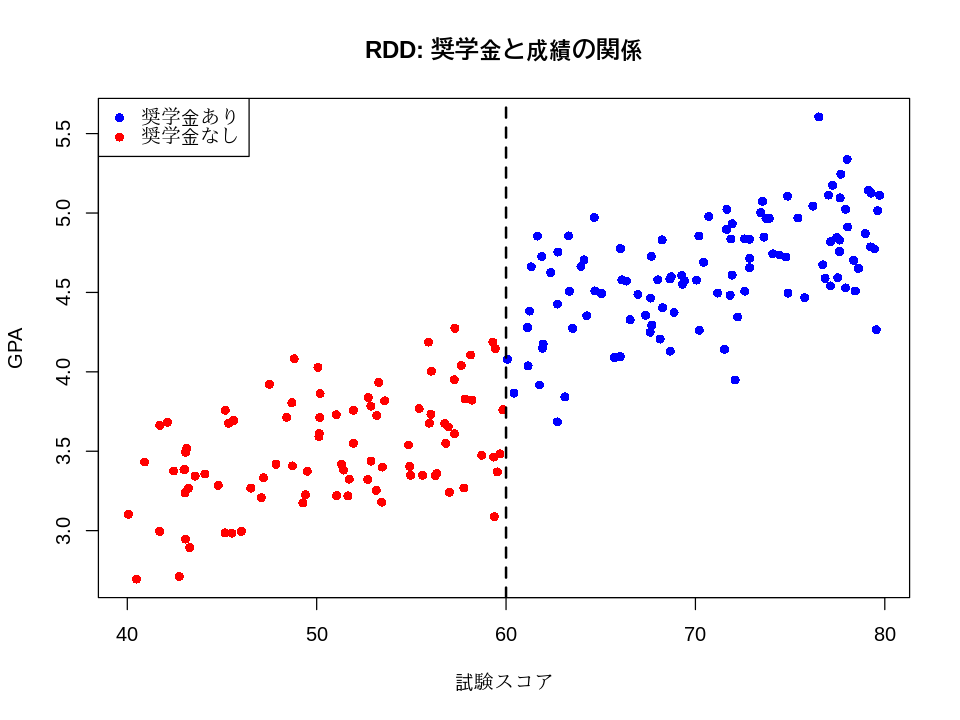

In [11]:
# データの生成
set.seed(456)
n <- 200
test_score <- runif(n, 40, 80)
scholarship <- ifelse(test_score >= 60, 1, 0)
gpa <- 2.0 + 0.03 * test_score + 0.5 * scholarship + rnorm(n, 0, 0.3)
rdd_data <- data.frame(test_score = test_score, scholarship = scholarship, gpa = gpa)

# 1. データの可視化
plot(rdd_data$test_score, rdd_data$gpa, 
     col = ifelse(rdd_data$scholarship == 1, "blue", "red"),
     pch = 16, xlab = "試験スコア", ylab = "GPA",
     main = "RDD: 奨学金と成績の関係")
abline(v = 60, lty = 2, lwd = 2)
legend("topleft", legend = c("奨学金あり", "奨学金なし"), 
       col = c("blue", "red"), pch = 16)

# 2. 単純なRDD回帰
model_rdd_simple <- lm(gpa ~ test_score + scholarship, data = rdd_data)
cat("単純なRDD回帰:\n")
summary(model_rdd_simple)

# 3. 閾値を中心としたスコア（センタリング）
rdd_data$score_centered <- rdd_data$test_score - 60
model_rdd_centered <- lm(gpa ~ score_centered + scholarship, data = rdd_data)
cat("\nセンタリングしたRDD回帰:\n")
summary(model_rdd_centered)

cat("\n推定された奨学金効果:", coef(model_rdd_centered)["scholarship"], "\n")
cat("真の効果: 0.5\n")

---
## 問題6: RDDにおける異なる傾きの許容

問題5のデータを使って、閾値の前後で傾きが異なることを許容したRDDモデルを推定してください。

1. 閾値の前後で傾きが異なるモデルを推定してください
2. 傾きが同じモデルと比較してください
3. 交互作用項の係数は何を意味するか説明してください

In [12]:
# ここに回答を入力してください


### 模範解答

傾きが異なることを許容したモデル:



Call:
lm(formula = gpa ~ score_centered + scholarship + score_centered:scholarship, 
    data = rdd_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.72805 -0.21909 -0.01187  0.22432  0.77659 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)                3.756222   0.057192  65.678  < 2e-16 ***
score_centered             0.026832   0.005314   5.050 1.01e-06 ***
scholarship                0.503378   0.081799   6.154 4.18e-09 ***
score_centered:scholarship 0.007627   0.007150   1.067    0.287    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2913 on 196 degrees of freedom
Multiple R-squared:  0.8047,	Adjusted R-squared:  0.8017 
F-statistic: 269.2 on 3 and 196 DF,  p-value: < 2.2e-16



モデルの比較（F検定）:


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,197,16.72812,NA,NA,NA,NA
2,196,16.63157,1,0.09654825,1.137804,0.2874291



解説:


score_centered:scholarship の係数は、閾値の上下でスコアとGPAの関係（傾き）が


どれだけ異なるかを表します。



この係数が統計的に有意でない場合、傾きは同じと仮定してもよいでしょう。


Warning message in title(...):
“conversion failure on 'RDD: 異なる傾きを許容' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(...):
“conversion failure on 'RDD: 異なる傾きを許容' in 'mbcsToSbcs': dot substituted for <95>”


Warning message in title(...):
“conversion failure on 'RDD: 異なる傾きを許容' in 'mbcsToSbcs': dot substituted for <b0>”


Warning message in title(...):
“conversion failure on 'RDD: 異なる傾きを許容' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'RDD: 異なる傾きを許容' in 'mbcsToSbcs': dot substituted for <81>”


Warning message in title(...):
“conversion failure on 'RDD: 異なる傾きを許容' in 'mbcsToSbcs': dot substituted for <aa>”


Warning message in title(...):
“conversion failure on 'RDD: 異なる傾きを許容' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'RDD: 異なる傾きを許容' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on 'RDD: 異なる傾きを許容' in 'mbcsToSbcs': dot substituted for <8b>”


Warning message in title(...):
“conversion failure on 'RDD: 異なる傾きを許容' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on 'RDD: 異なる傾きを許容' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on 'RDD: 異なる傾きを許容' in 'mbcsToSbcs': dot substituted for <be>”


Warning message in title(...):
“conversion failure on 'RDD: 異なる傾きを許容' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'RDD: 異なる傾きを許容' in 'mbcsToSbcs': dot substituted for <81>”


Warning message in title(...):
“conversion failure on 'RDD: 異なる傾きを許容' in 'mbcsToSbcs': dot substituted for <8d>”


Warning message in title(...):
“conversion failure on 'RDD: 異なる傾きを許容' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'RDD: 異なる傾きを許容' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on 'RDD: 異なる傾きを許容' in 'mbcsToSbcs': dot substituted for <92>”


Warning message in title(...):
“conversion failure on 'RDD: 異なる傾きを許容' in 'mbcsToSbcs': dot substituted for <e8>”


Warning message in title(...):
“conversion failure on 'RDD: 異なる傾きを許容' in 'mbcsToSbcs': dot substituted for <a8>”


Warning message in title(...):
“conversion failure on 'RDD: 異なる傾きを許容' in 'mbcsToSbcs': dot substituted for <b1>”


Warning message in title(...):
“conversion failure on 'RDD: 異なる傾きを許容' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on 'RDD: 異なる傾きを許容' in 'mbcsToSbcs': dot substituted for <ae>”


Warning message in title(...):
“conversion failure on 'RDD: 異なる傾きを許容' in 'mbcsToSbcs': dot substituted for <b9>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <e8>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <a9>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <a6>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <e9>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <a8>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <93>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <b9>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <b3>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <a2>”


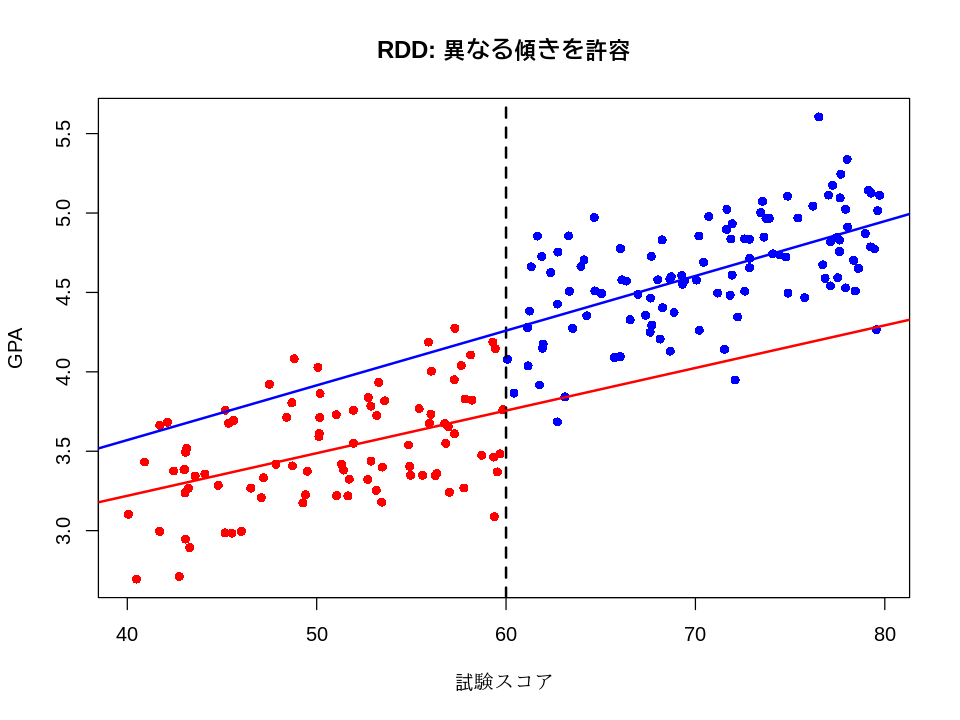

In [13]:
# 問題5のデータを再利用
set.seed(456)
n <- 200
test_score <- runif(n, 40, 80)
scholarship <- ifelse(test_score >= 60, 1, 0)
gpa <- 2.0 + 0.03 * test_score + 0.5 * scholarship + rnorm(n, 0, 0.3)
rdd_data <- data.frame(test_score = test_score, scholarship = scholarship, gpa = gpa)
rdd_data$score_centered <- rdd_data$test_score - 60

# 1. 傾きが異なるモデル
model_diff_slopes <- lm(gpa ~ score_centered + scholarship + score_centered:scholarship, 
                        data = rdd_data)
cat("傾きが異なることを許容したモデル:\n")
summary(model_diff_slopes)

# 2. 傾きが同じモデルとの比較
model_same_slopes <- lm(gpa ~ score_centered + scholarship, data = rdd_data)

cat("\nモデルの比較（F検定）:\n")
anova(model_same_slopes, model_diff_slopes)

# 3. 解説
cat("\n解説:\n")
cat("score_centered:scholarship の係数は、閾値の上下でスコアとGPAの関係（傾き）が\n")
cat("どれだけ異なるかを表します。\n")
cat("\nこの係数が統計的に有意でない場合、傾きは同じと仮定してもよいでしょう。\n")

# グラフで確認
plot(rdd_data$test_score, rdd_data$gpa, 
     col = ifelse(rdd_data$scholarship == 1, "blue", "red"),
     pch = 16, xlab = "試験スコア", ylab = "GPA",
     main = "RDD: 異なる傾きを許容")
abline(v = 60, lty = 2, lwd = 2)

# 回帰直線を追加
abline(a = coef(model_diff_slopes)[1] - 60 * coef(model_diff_slopes)[2], 
       b = coef(model_diff_slopes)[2], col = "red", lwd = 2)
abline(a = coef(model_diff_slopes)[1] + coef(model_diff_slopes)[3] - 
       60 * (coef(model_diff_slopes)[2] + coef(model_diff_slopes)[4]), 
       b = coef(model_diff_slopes)[2] + coef(model_diff_slopes)[4], col = "blue", lwd = 2)

---
## 問題7: RDDのバンド幅選択

RDDでは閾値周辺のデータのみを使用する「局所線形回帰」が一般的です。

問題5のデータを使って、異なるバンド幅での推定結果を比較してください。

1. 閾値から±5点以内のデータで推定してください
2. 閾値から±10点以内のデータで推定してください
3. 閾値から±20点以内のデータで推定してください
4. バンド幅の選択がどのように結果に影響するか考察してください

In [14]:
# ここに回答を入力してください


### 模範解答

異なるバンド幅での推定結果:


             bandwidth  estimate         se n_obs
scholarship          5 0.4789168 0.20036401    52
scholarship1        10 0.6022342 0.11441063   102
scholarship2        20 0.5017353 0.08181289   200


Warning message in title(...):
“conversion failure on 'バンド幅 ± 5 点' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 5 点' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 5 点' in 'mbcsToSbcs': dot substituted for <90>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 5 点' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 5 点' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 5 点' in 'mbcsToSbcs': dot substituted for <b3>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 5 点' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 5 点' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 5 点' in 'mbcsToSbcs': dot substituted for <89>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 5 点' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 5 点' in 'mbcsToSbcs': dot substituted for <b9>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 5 点' in 'mbcsToSbcs': dot substituted for <85>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 5 点' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 5 点' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 5 点' in 'mbcsToSbcs': dot substituted for <b9>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <e8>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <a9>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <a6>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <e9>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <a8>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <93>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <b9>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <b3>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <a2>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 10 点' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 10 点' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 10 点' in 'mbcsToSbcs': dot substituted for <90>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 10 点' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 10 点' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 10 点' in 'mbcsToSbcs': dot substituted for <b3>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 10 点' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 10 点' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 10 点' in 'mbcsToSbcs': dot substituted for <89>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 10 点' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 10 点' in 'mbcsToSbcs': dot substituted for <b9>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 10 点' in 'mbcsToSbcs': dot substituted for <85>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 10 点' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 10 点' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 10 点' in 'mbcsToSbcs': dot substituted for <b9>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <e8>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <a9>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <a6>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <e9>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <a8>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <93>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <b9>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <b3>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <a2>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 20 点' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 20 点' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 20 点' in 'mbcsToSbcs': dot substituted for <90>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 20 点' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 20 点' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 20 点' in 'mbcsToSbcs': dot substituted for <b3>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 20 点' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 20 点' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 20 点' in 'mbcsToSbcs': dot substituted for <89>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 20 点' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 20 点' in 'mbcsToSbcs': dot substituted for <b9>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 20 点' in 'mbcsToSbcs': dot substituted for <85>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 20 点' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 20 点' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on 'バンド幅 ± 20 点' in 'mbcsToSbcs': dot substituted for <b9>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <e8>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <a9>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <a6>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <e9>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <a8>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <93>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <b9>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <b3>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on '試験スコア' in 'mbcsToSbcs': dot substituted for <a2>”



考察:


- 狭いバンド幅: バイアスは小さいが、サンプルサイズが減り分散が大きくなる


- 広いバンド幅: サンプルサイズは大きいが、閾値から遠いデータを含むためバイアスが生じうる


- 最適なバンド幅はバイアスと分散のトレードオフで決定される


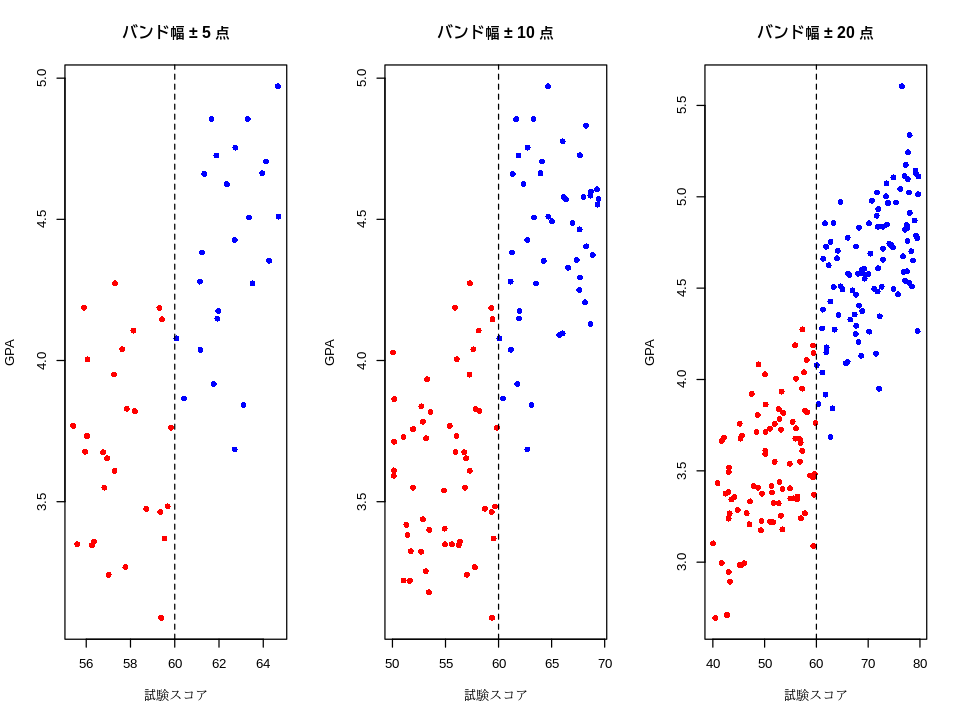

In [15]:
# 問題5のデータを再利用
set.seed(456)
n <- 200
test_score <- runif(n, 40, 80)
scholarship <- ifelse(test_score >= 60, 1, 0)
gpa <- 2.0 + 0.03 * test_score + 0.5 * scholarship + rnorm(n, 0, 0.3)
rdd_data <- data.frame(test_score = test_score, scholarship = scholarship, gpa = gpa)
rdd_data$score_centered <- rdd_data$test_score - 60

# 異なるバンド幅での推定
bandwidths <- c(5, 10, 20)
results <- data.frame(bandwidth = numeric(), estimate = numeric(), 
                      se = numeric(), n_obs = numeric())

for (bw in bandwidths) {
  subset_data <- rdd_data[abs(rdd_data$score_centered) <= bw, ]
  model <- lm(gpa ~ score_centered + scholarship, data = subset_data)
  
  results <- rbind(results, data.frame(
    bandwidth = bw,
    estimate = coef(model)["scholarship"],
    se = summary(model)$coefficients["scholarship", "Std. Error"],
    n_obs = nrow(subset_data)
  ))
}

cat("異なるバンド幅での推定結果:\n")
print(results)

# 可視化
par(mfrow = c(1, 3))
for (bw in bandwidths) {
  subset_data <- rdd_data[abs(rdd_data$score_centered) <= bw, ]
  plot(subset_data$test_score, subset_data$gpa, 
       col = ifelse(subset_data$scholarship == 1, "blue", "red"),
       pch = 16, main = paste("バンド幅 ±", bw, "点"),
       xlab = "試験スコア", ylab = "GPA")
  abline(v = 60, lty = 2)
}
par(mfrow = c(1, 1))

cat("\n考察:\n")
cat("- 狭いバンド幅: バイアスは小さいが、サンプルサイズが減り分散が大きくなる\n")
cat("- 広いバンド幅: サンプルサイズは大きいが、閾値から遠いデータを含むためバイアスが生じうる\n")
cat("- 最適なバンド幅はバイアスと分散のトレードオフで決定される\n")

---
## 問題8: ファジーRDD

シャープRDDでは閾値で処置が完全に決定されますが、ファジーRDDでは処置確率が変化するだけです。

```r
set.seed(789)
n <- 300
test_score <- runif(n, 40, 80)
# 閾値を超えると奨学金を受ける確率が上昇（完全ではない）
prob_scholarship <- ifelse(test_score >= 60, 0.8, 0.2)
scholarship <- rbinom(n, 1, prob_scholarship)
gpa <- 2.0 + 0.03 * test_score + 0.5 * scholarship + rnorm(n, 0, 0.3)
fuzzy_data <- data.frame(test_score = test_score, scholarship = scholarship, gpa = gpa)
```

1. 閾値の前後での奨学金受給率を確認してください
2. 通常のOLS回帰で効果を推定してください
3. 閾値を操作変数として2SLS推定を行ってください

In [16]:
# ここに回答を入力してください


### 模範解答

In [17]:
# データの生成
set.seed(789)
n <- 300
test_score <- runif(n, 40, 80)
prob_scholarship <- ifelse(test_score >= 60, 0.8, 0.2)
scholarship <- rbinom(n, 1, prob_scholarship)
gpa <- 2.0 + 0.03 * test_score + 0.5 * scholarship + rnorm(n, 0, 0.3)
fuzzy_data <- data.frame(test_score = test_score, scholarship = scholarship, gpa = gpa)
fuzzy_data$above_cutoff <- ifelse(fuzzy_data$test_score >= 60, 1, 0)
fuzzy_data$score_centered <- fuzzy_data$test_score - 60

# 1. 閾値前後での奨学金受給率
cat("閾値未満（スコア < 60）での奨学金受給率:", 
    mean(fuzzy_data$scholarship[fuzzy_data$above_cutoff == 0]), "\n")
cat("閾値以上（スコア >= 60）での奨学金受給率:", 
    mean(fuzzy_data$scholarship[fuzzy_data$above_cutoff == 1]), "\n\n")

# 2. 通常のOLS回帰
model_ols <- lm(gpa ~ score_centered + scholarship, data = fuzzy_data)
cat("OLS推定:\n")
summary(model_ols)

# 3. 2SLS推定（閾値を操作変数として使用）
model_2sls <- ivreg(gpa ~ score_centered + scholarship | score_centered + above_cutoff, 
                    data = fuzzy_data)
cat("\n2SLS推定（ファジーRDD）:\n")
summary(model_2sls)

cat("\n比較:\n")
cat("OLS推定値:", coef(model_ols)["scholarship"], "\n")
cat("2SLS推定値:", coef(model_2sls)["scholarship"], "\n")
cat("真の効果: 0.5\n")
cat("\nファジーRDDでは、閾値を超えることによる処置確率の変化を利用して\n")
cat("局所的な平均処置効果（LATE）を推定します。\n")

閾値未満（スコア < 60）での奨学金受給率: 0.2027027 


閾値以上（スコア >= 60）での奨学金受給率: 0.7434211 



OLS推定:



Call:
lm(formula = gpa ~ score_centered + scholarship, data = fuzzy_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.9765 -0.1860  0.0131  0.1954  0.7736 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)     3.81475    0.02462  154.96   <2e-16 ***
score_centered  0.03010    0.00168   17.92   <2e-16 ***
scholarship     0.52090    0.03804   13.69   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2889 on 297 degrees of freedom
Multiple R-squared:  0.7647,	Adjusted R-squared:  0.7631 
F-statistic: 482.5 on 2 and 297 DF,  p-value: < 2.2e-16



2SLS推定（ファジーRDD）:



Call:
ivreg(formula = gpa ~ score_centered + scholarship | score_centered + 
    above_cutoff, data = fuzzy_data)

Residuals:
      Min        1Q    Median        3Q       Max 
-1.018000 -0.174621  0.006241  0.180458  0.782913 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    3.762349   0.066036  56.974  < 2e-16 ***
score_centered 0.027771   0.003206   8.661 3.04e-16 ***
scholarship    0.630973   0.134092   4.706 3.89e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2929 on 297 degrees of freedom
Multiple R-Squared: 0.758,	Adjusted R-squared: 0.7564 
Wald test: 389.2 on 2 and 297 DF,  p-value: < 2.2e-16 



比較:


OLS推定値: 0.5209001 


2SLS推定値: 0.6309735 


真の効果: 0.5



ファジーRDDでは、閾値を超えることによる処置確率の変化を利用して


局所的な平均処置効果（LATE）を推定します。


---
## 問題9: DIDにおける複数期間の分析

複数期間のパネルデータを使ったDID分析を行います。

```r
set.seed(111)
n_units <- 50
n_periods <- 6
treatment_time <- 4  # 期間4から処置開始

panel_did <- expand.grid(unit = 1:n_units, time = 1:n_periods)
panel_did$treat_group <- ifelse(panel_did$unit <= 25, 1, 0)
panel_did$post <- ifelse(panel_did$time >= treatment_time, 1, 0)
panel_did$treated <- panel_did$treat_group * panel_did$post

# 固定効果とトレンドを含むアウトカム
unit_fe <- rnorm(n_units, 0, 5)
time_fe <- c(0, 2, 4, 6, 8, 10)
panel_did$y <- 50 + unit_fe[panel_did$unit] + time_fe[panel_did$time] + 
               10 * panel_did$treated + rnorm(n_units * n_periods, 0, 3)
```

1. グループ別の時系列推移を可視化してください
2. 固定効果を含むDIDモデルを推定してください
3. クラスター頑健標準誤差を計算してください

In [18]:
# ここに回答を入力してください


### 模範解答

Warning message in title(...):
“conversion failure on 'グループ別の時系列推移' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'グループ別の時系列推移' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on 'グループ別の時系列推移' in 'mbcsToSbcs': dot substituted for <b0>”


Warning message in title(...):
“conversion failure on 'グループ別の時系列推移' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'グループ別の時系列推移' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'グループ別の時系列推移' in 'mbcsToSbcs': dot substituted for <ab>”


Warning message in title(...):
“conversion failure on 'グループ別の時系列推移' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'グループ別の時系列推移' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'グループ別の時系列推移' in 'mbcsToSbcs': dot substituted for <bc>”


Warning message in title(...):
“conversion failure on 'グループ別の時系列推移' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'グループ別の時系列推移' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'グループ別の時系列推移' in 'mbcsToSbcs': dot substituted for <97>”


Warning message in title(...):
“conversion failure on 'グループ別の時系列推移' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on 'グループ別の時系列推移' in 'mbcsToSbcs': dot substituted for <88>”


Warning message in title(...):
“conversion failure on 'グループ別の時系列推移' in 'mbcsToSbcs': dot substituted for <a5>”


Warning message in title(...):
“conversion failure on 'グループ別の時系列推移' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'グループ別の時系列推移' in 'mbcsToSbcs': dot substituted for <81>”


Warning message in title(...):
“conversion failure on 'グループ別の時系列推移' in 'mbcsToSbcs': dot substituted for <ae>”


Warning message in title(...):
“conversion failure on 'グループ別の時系列推移' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(...):
“conversion failure on 'グループ別の時系列推移' in 'mbcsToSbcs': dot substituted for <99>”


Warning message in title(...):
“conversion failure on 'グループ別の時系列推移' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on 'グループ別の時系列推移' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(...):
“conversion failure on 'グループ別の時系列推移' in 'mbcsToSbcs': dot substituted for <b3>”


Warning message in title(...):
“conversion failure on 'グループ別の時系列推移' in 'mbcsToSbcs': dot substituted for <bb>”


Warning message in title(...):
“conversion failure on 'グループ別の時系列推移' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on 'グループ別の時系列推移' in 'mbcsToSbcs': dot substituted for <88>”


Warning message in title(...):
“conversion failure on 'グループ別の時系列推移' in 'mbcsToSbcs': dot substituted for <97>”


Warning message in title(...):
“conversion failure on 'グループ別の時系列推移' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(...):
“conversion failure on 'グループ別の時系列推移' in 'mbcsToSbcs': dot substituted for <8e>”


Warning message in title(...):
“conversion failure on 'グループ別の時系列推移' in 'mbcsToSbcs': dot substituted for <a8>”


Warning message in title(...):
“conversion failure on 'グループ別の時系列推移' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(...):
“conversion failure on 'グループ別の時系列推移' in 'mbcsToSbcs': dot substituted for <a7>”


Warning message in title(...):
“conversion failure on 'グループ別の時系列推移' in 'mbcsToSbcs': dot substituted for <bb>”


Warning message in title(...):
“conversion failure on '期間' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(...):
“conversion failure on '期間' in 'mbcsToSbcs': dot substituted for <9c>”


Warning message in title(...):
“conversion failure on '期間' in 'mbcsToSbcs': dot substituted for <9f>”


Warning message in title(...):
“conversion failure on '期間' in 'mbcsToSbcs': dot substituted for <e9>”


Warning message in title(...):
“conversion failure on '期間' in 'mbcsToSbcs': dot substituted for <96>”


Warning message in title(...):
“conversion failure on '期間' in 'mbcsToSbcs': dot substituted for <93>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <a2>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <a6>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <88>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <ab>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'アウトカム' in 'mbcsToSbcs': dot substituted for <a0>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <87>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <a6>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <bd>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <ae>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <be>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <a4>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <af>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <be>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <85>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <a7>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <be>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <a4>”


Warning message in text.default(x, y, ...):
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in text.default(x, y, ...):
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <87>”


Warning message in text.default(x, y, ...):
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <a6>”


Warning message in text.default(x, y, ...):
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in text.default(x, y, ...):
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <bd>”


Warning message in text.default(x, y, ...):
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <ae>”


Warning message in text.default(x, y, ...):
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in text.default(x, y, ...):
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <be>”


Warning message in text.default(x, y, ...):
“conversion failure on '処置群' in 'mbcsToSbcs': dot substituted for <a4>”


Warning message in text.default(x, y, ...):
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in text.default(x, y, ...):
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <af>”


Warning message in text.default(x, y, ...):
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <be>”


Warning message in text.default(x, y, ...):
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in text.default(x, y, ...):
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <85>”


Warning message in text.default(x, y, ...):
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <a7>”


Warning message in text.default(x, y, ...):
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in text.default(x, y, ...):
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <be>”


Warning message in text.default(x, y, ...):
“conversion failure on '対照群' in 'mbcsToSbcs': dot substituted for <a4>”


Two-way Fixed Effects DIDモデル:


処置効果の推定値: 8.882894 


（ユニット固定効果と時間固定効果は省略）



クラスター頑健標準誤差を使用した結果:


    Estimate   Std. Error      t value     Pr(>|t|) 
8.882894e+00 7.491028e-01 1.185804e+01 6.484831e-26 



真の処置効果: 10


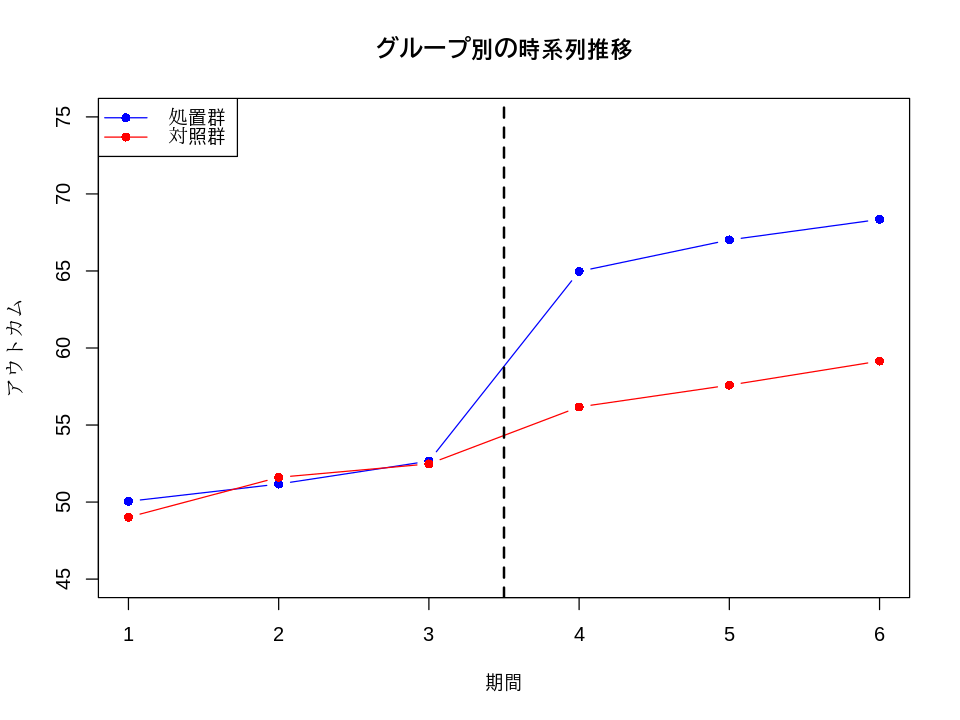

In [19]:
# データの生成
set.seed(111)
n_units <- 50
n_periods <- 6
treatment_time <- 4

panel_did <- expand.grid(unit = 1:n_units, time = 1:n_periods)
panel_did$treat_group <- ifelse(panel_did$unit <= 25, 1, 0)
panel_did$post <- ifelse(panel_did$time >= treatment_time, 1, 0)
panel_did$treated <- panel_did$treat_group * panel_did$post

unit_fe <- rnorm(n_units, 0, 5)
time_fe <- c(0, 2, 4, 6, 8, 10)
panel_did$y <- 50 + unit_fe[panel_did$unit] + time_fe[panel_did$time] + 
               10 * panel_did$treated + rnorm(n_units * n_periods, 0, 3)

# 1. グループ別の時系列推移の可視化
group_means <- aggregate(y ~ time + treat_group, data = panel_did, mean)

plot(1:n_periods, group_means$y[group_means$treat_group == 1], 
     type = "b", col = "blue", pch = 16, ylim = c(45, 75),
     xlab = "期間", ylab = "アウトカム", main = "グループ別の時系列推移")
lines(1:n_periods, group_means$y[group_means$treat_group == 0], 
      type = "b", col = "red", pch = 16)
abline(v = treatment_time - 0.5, lty = 2, lwd = 2)
legend("topleft", legend = c("処置群", "対照群"), col = c("blue", "red"), 
       lty = 1, pch = 16)

# 2. 固定効果を含むDIDモデル
panel_did$unit <- factor(panel_did$unit)
panel_did$time <- factor(panel_did$time)

model_twfe <- lm(y ~ treated + unit + time, data = panel_did)
cat("Two-way Fixed Effects DIDモデル:\n")
cat("処置効果の推定値:", coef(model_twfe)["treated"], "\n")
cat("（ユニット固定効果と時間固定効果は省略）\n\n")

# 3. クラスター頑健標準誤差
cluster_se <- coeftest(model_twfe, vcov = vcovCL(model_twfe, cluster = panel_did$unit))
cat("クラスター頑健標準誤差を使用した結果:\n")
print(cluster_se["treated", ])

cat("\n真の処置効果: 10\n")

---
## 問題10: 処置効果の異質性

RCTのデータを使って、処置効果が共変量によって異なるかを検討します。

```r
set.seed(222)
n <- 400
treatment <- rbinom(n, 1, 0.5)
gender <- rbinom(n, 1, 0.5)  # 0 = 女性, 1 = 男性
age <- sample(18:65, n, replace = TRUE)

# 処置効果は性別によって異なる（女性: 5, 男性: 10）
treatment_effect <- 5 + 5 * gender
y <- 50 + treatment_effect * treatment + 0.1 * age + rnorm(n, 0, 10)
heterog_data <- data.frame(treatment = treatment, gender = gender, age = age, y = y)
```

1. 全体の処置効果を推定してください
2. 性別ごとの処置効果を推定してください
3. 交互作用項を使って処置効果の異質性を検定してください

In [20]:
# ここに回答を入力してください


### 模範解答

In [21]:
# データの生成
set.seed(222)
n <- 400
treatment <- rbinom(n, 1, 0.5)
gender <- rbinom(n, 1, 0.5)
age <- sample(18:65, n, replace = TRUE)

treatment_effect <- 5 + 5 * gender
y <- 50 + treatment_effect * treatment + 0.1 * age + rnorm(n, 0, 10)
heterog_data <- data.frame(treatment = treatment, gender = gender, age = age, y = y)

# 1. 全体の処置効果
model_overall <- lm(y ~ treatment + age, data = heterog_data)
cat("全体の処置効果:\n")
summary(model_overall)

# 2. 性別ごとの処置効果
model_female <- lm(y ~ treatment + age, data = heterog_data[heterog_data$gender == 0, ])
model_male <- lm(y ~ treatment + age, data = heterog_data[heterog_data$gender == 1, ])

cat("\n女性の処置効果:", coef(model_female)["treatment"], "\n")
cat("男性の処置効果:", coef(model_male)["treatment"], "\n")

# 3. 交互作用項を使った検定
model_interaction <- lm(y ~ treatment * gender + age, data = heterog_data)
cat("\n交互作用モデル:\n")
summary(model_interaction)

cat("\n解釈:\n")
cat("- treatment: 女性（gender=0）における処置効果\n")
cat("- treatment:gender: 男性の処置効果と女性の処置効果の差\n")
cat("\n真の値:\n")
cat("女性の処置効果: 5\n")
cat("男性の処置効果: 10\n")
cat("処置効果の差: 5\n")

全体の処置効果:



Call:
lm(formula = y ~ treatment + age, data = heterog_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-26.140  -6.924   0.022   7.116  33.088 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 51.20857    1.70773  29.986  < 2e-16 ***
treatment    7.82971    1.02535   7.636 1.69e-13 ***
age          0.05151    0.03697   1.393    0.164    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.25 on 397 degrees of freedom
Multiple R-squared:  0.133,	Adjusted R-squared:  0.1286 
F-statistic: 30.44 on 2 and 397 DF,  p-value: 5.008e-13



女性の処置効果: 4.563413 


男性の処置効果: 10.653 



交互作用モデル:



Call:
lm(formula = y ~ treatment * gender + age, data = heterog_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-26.0206  -7.0129  -0.1185   6.7400  30.2347 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      50.58039    1.82373  27.735  < 2e-16 ***
treatment         4.57916    1.43347   3.194  0.00151 ** 
gender            0.23865    1.43568   0.166  0.86806    
age               0.06378    0.03626   1.759  0.07933 .  
treatment:gender  6.07577    2.00848   3.025  0.00265 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.02 on 395 degrees of freedom
Multiple R-squared:  0.1751,	Adjusted R-squared:  0.1668 
F-statistic: 20.97 on 4 and 395 DF,  p-value: 1.091e-15



解釈:


- treatment: 女性（gender=0）における処置効果


- treatment:gender: 男性の処置効果と女性の処置効果の差



真の値:


女性の処置効果: 5


男性の処置効果: 10


処置効果の差: 5


---
## まとめ

この章では以下の内容を学びました：

1. **ランダム化比較試験（RCT）**: 因果効果を推定するためのゴールドスタンダード
2. **共変量調整**: RCTでも共変量を含めることで推定精度が向上
3. **差の差分析（DID）**: 処置群と対照群の変化の差から因果効果を推定
4. **平行トレンド仮定**: DIDの妥当性を支える重要な仮定
5. **回帰不連続デザイン（RDD）**: 閾値周辺での不連続性を利用した因果推論
6. **バンド幅選択**: RDDにおけるバイアスと分散のトレードオフ
7. **ファジーRDD**: 処置確率が不連続に変化する場合の対処法
8. **処置効果の異質性**: サブグループごとに異なる処置効果の推定